In [10]:
import pandas as pd
import numpy as np

Apply the Random Forests algorithm but this time only by upscaling the data.

In [11]:
categorical = pd.read_csv('files_for_lab/categorical.csv')
numerical = pd.read_csv('files_for_lab/numerical.csv')
target = pd.read_csv('files_for_lab/target.csv')

In [12]:
#encode the categoricals
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(categorical)
encoded_categorical = encoder.transform(categorical).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)

In [13]:
data = pd.concat([encoded_categorical, numerical, target], axis=1)

In [14]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B,TARGET_D
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,10.0,4,7.741935,95515,0,4,39,0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,25.0,18,15.666667,148535,0,2,1,0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,16.0,5.0,12,7.481481,15078,1,4,60,0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,10.0,9,6.812500,172556,1,4,41,0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,15.0,14,6.864865,7112,1,2,26,0,0.0


In [15]:
data['TARGET_D'].sum()

75668.7

In [16]:
data.TARGET_B.value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [17]:
#upsample
from sklearn.utils import resample
majority_class = data[data.TARGET_B == 0]
minority_class = data[data.TARGET_B == 1]

minority_class_upsampled = resample(minority_class, 
                                   replace=True, 
                                   n_samples = len(majority_class))

data_upsampled = pd.concat([majority_class, minority_class_upsampled], axis=0)

In [18]:
data_upsampled.shape

(181138, 636)

In [19]:
#X-y split
y = data_upsampled['TARGET_B']
X = data_upsampled.drop(['TARGET_B'], axis=1)

#train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train_regression = X_train['TARGET_D']
y_test_regression = X_test['TARGET_D']


X_train = X_train.drop(['TARGET_D'], axis = 1)
X_test = X_test.drop(['TARGET_D'], axis = 1)

In [20]:
#building the Random Forest classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)

clf.fit(X_train, y_train)
print('train score: ',clf.score(X_train, y_train))
print('test score: ',clf.score(X_test, y_test))

train score:  0.613946587537092
test score:  0.608148393507784


In [21]:
#cross validation score
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.6130494789869575


Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

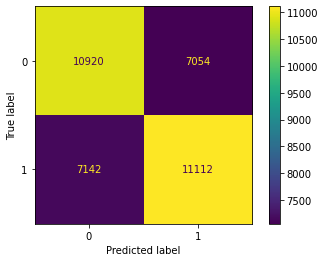

In [22]:
#confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)

The false positives are people that were predicted to donate but did not donate, and the false negatives are the people that were predicted to be non-donors but did actually donate. 

In this case if we only send the promotional mail to the predicted donors the cost of a false negative(missing out on a donation) is far more than the cost of a false positive(the cost of postage). 

It would be best to focus on minimizing the false negatives in order to increase total donation amount. We can lower the threshold for a positive prediction in order to increase the amount of positives predicted. The optimal donor probability threshold for maximum revenue would depend on the cost of postage of each promotional mail(not included in the case study) and the estimated donation amounts(which I will build a model to predict in the next lab).  

In [26]:
#adding predictions to dataset
y = data['TARGET_D']
X = data.drop(['TARGET_D', 'TARGET_B'], axis=1)

pred = clf.predict(X)
pred_prob = clf.predict_proba(X)

data['predicted_donor'] = pred
data['predicted_donor_prob'] = [pred_prob[i][1] for i in range(len(pred_prob))]
data.head()

,0,1,2,3,4,5,6,7,8,9,...,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B,TARGET_D,predicted_donor,predicted_donor_prob
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,7.741935,95515,0,4,39,0,0.0,1,0.556004
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18,15.666667,148535,0,2,1,0,0.0,0,0.497439
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,12,7.481481,15078,1,4,60,0,0.0,1,0.537028
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,6.812500,172556,1,4,41,0,0.0,1,0.571061
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14,6.864865,7112,1,2,26,0,0.0,0,0.465039


In [28]:
#find threshold to optimize donations
best_threshold = 0
highest_revenue = 0

for i in range(30,50):
    d = data[data['predicted_donor_prob']>=(i/100)]
    cost = .68*len(d)
    donations = d['TARGET_D'].sum()
    revenue = donations - cost
    if revenue > highest_revenue:
        highest_revenue = revenue
        best_threshold = i/100
    
print('highest revenue: ', highest_revenue, ' best threshold: ', best_threshold)

highest revenue:  16370.55999999999  best threshold:  0.45


For the current dataset, if we assume that each piece of promotional mail cost 68 cents(I did not see this in the case study documentation but was mentioned in class) and all 95412 potential donors were to receive one, that would cost the company $64880.16. The total amount of donations received was $75668.70, leaving $10788.54 in revenue.

But if they had instead only sent it to the potential donors that the model predicted at least .45 probability of donating, the revenue would have increased to $16370.55.